In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ex2data2.txt
/kaggle/input/ex2data1.txt


# Programming Exercise 1: Logistic Regression

# 1 Logistic Regression

In [2]:
'''
Load Data
The first two columns contains the exam scores and the third column contains the label.
'''
df1 = pd.read_csv('../input/ex2data1.txt', header=None)
df1.columns = ['Exam 1 score', 'Exam 2 score', 'Admitted']
#df1['Admitted'] = df1['Admitted'].astype('category')

data = df1
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

print(X.shape)
print(y.shape)

(100, 2)
(100,)


## 1.1 Visualizing the data

plots the data points with + for the positive examples and o for the negative examples. 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.



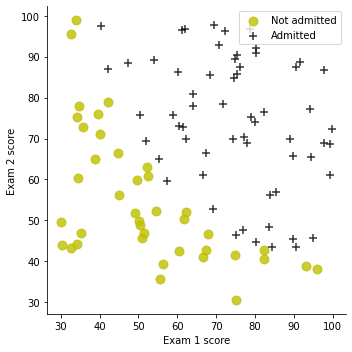

In [4]:
print('Plotting data with + indicating (y = 1) examples and o indicating (y = 0) examples.\n');

# plot with pandas dataframe

ax = sns.lmplot(x = 'Exam 1 score' , y = 'Exam 2 score', data = df1,
                hue = 'Admitted', 
                markers = ['o', '+'], palette = ['y', 'k'],
                fit_reg=False, scatter_kws = {'s':80}, legend = False)
# scatterplot/relplot/regplot allows only a very limited set of markers

ax.set(xlabel = 'Exam 1 score', ylabel = 'Exam 2 score')

#ax._legend.set(title = '')
#new_labels = ['Not admitted', 'Admitted']
#for t, l in zip(ax._legend.texts, new_labels): 
#    t.set_text(l)

# add new legend instead of using the legend with sns
plt.legend(title = '', loc = 'upper right', labels = ['Not admitted', 'Admitted'])

    

## 1.2 Implementation
### 1.2.1 Warmup: sigmoid function

In [5]:
def sigmoid(z):
    '''
    SIGMOID Compute sigmoid functoon
    '''
    return 1/(1+np.exp(-z))

### 1.2.2 Compute Cost and Gradient

the two functions are separated due to the input to the scipy optimization function in the following section

In [6]:
def costFunction(theta, X, y):
    '''
    COSTFUNCTION Compute cost and gradient for logistic regression
    
    J = COSTFUNCTION(theta, X, y) computes the cost of using theta as the
    parameter for logistic regression and 
    
    X - shape (m, n)
    theta - nparray shape (n+1,)
    '''
    # Setup the data matrix appropriately, and add ones for the intercept term
    m,n = X.shape
    
    # Add intercept term to X
    X = np.hstack([np.ones((m,1)), X]) # Add a column of ones to x
    
    m = len(y) # number of training examples
    #n = X.shape[1]-1
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)
    
    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
    
    # sum(-log(h(x))) for y = 1
    y_1_useful = y_prob * y 
    J_y_1_sum = -sum(np.log(y_1_useful[y_1_useful!=0]))
    
    # sum(-log(h(x))) for y = 0
    y_0_useful = (1 - y_prob) * (1-y)
    J_y_0_sum = -sum(np.log(y_0_useful[y_0_useful!=0]))
    
    return (J_y_1_sum + J_y_0_sum)/m

def gradientFunction(theta, X, y):
    '''
    computes the gradient of the cost w.r.t. to the parameters.
    X - shape (m, n)
    theta - nparray shape (n+1,)
    '''
    # Setup the data matrix appropriately, and add ones for the intercept term
    m,n = X.shape
    
    # Add intercept term to X
    X = np.hstack([np.ones((m,1)), X]) # Add a column of ones to x
    
    m = len(y) # number of training examples
    #n = X.shape[1]-1
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)

    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
    
    return (X.T @ (y_prob - y))/m # (n+1,1)

In [7]:
m, n = X.shape
# Initialize fitting parameters
initial_theta = np.zeros(n + 1)


# Compute and display initial cost and gradient
cost = costFunction(initial_theta, X, y)
grad = gradientFunction(initial_theta, X, y)

print('Cost at initial theta (zeros): {}\n'.format(cost))
print('Gradient at initial theta (zeros): \n{}\n'.format(grad.flatten().tolist()))


Cost at initial theta (zeros): 0.693147180559945

Gradient at initial theta (zeros): 
[-0.1, -12.00921658929115, -11.262842205513593]



### 1.2.3 Learning parameters using *fminunc*

Unconstrained minimization of a function using the Newton-Conjugate-Gradient method
fmin_ncg - unconstrained minimization
fmin_tnc - box constrained - lower and upper bounds

fmin_tnc only takes 1d array

In [8]:
from scipy.optimize import fmin_tnc

# get optimal theta
temp = fmin_tnc(func = costFunction, x0 = initial_theta, fprime= gradientFunction, args = (X, y))

theta = temp[0]
# Print theta to screen
print('Cost at theta found by fminunc: {}\n'.format(costFunction(theta, X, y)))
print('theta: \n{}\n'.format(theta))


Cost at theta found by fminunc: 0.20349770158947492

theta: 
[-25.16131854   0.20623159   0.20147149]



### 1.2.4 Evaluating logistic regression

In [9]:
def predict(theta, X):
    '''
    PREDICT Predict whether the label is 0 or 1 using learned logistic regression parameters theta
    p = PREDICT(theta, X) computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)
    
    returns a 1d array with binary predictions
    '''
    m,n = X.shape
    
    # Add intercept term to X
    X = np.hstack([np.ones((m,1)), X]) # Add a column of ones to x (m, n+1)
    
    m = len(y) # number of training examples
    
    theta = theta.reshape(n+1,1)
    
    y_prob = sigmoid(X @ theta)
    
    y_pred = (y_prob >= 0.5).astype(int)
    
    return y_pred.flatten()

In [10]:
prob = sigmoid(np.array([1,45,85]) @ theta)
print('For a student with scores 45 and 85, we predict an admission probability of {:.4f}\n\n'.format(prob))

For a student with scores 45 and 85, we predict an admission probability of 0.7763




In [11]:
# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %{:.2f}\n'.format(np.mean(p == y)*100))

Train Accuracy: %89.00



plot decision boundary

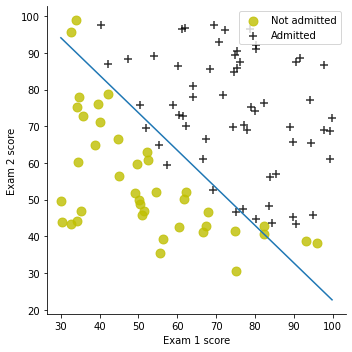

In [12]:
ax1 = sns.lmplot(x = 'Exam 1 score' , y = 'Exam 2 score', data = df1,
                hue = 'Admitted', 
                markers = ['o', '+'], palette = ['y', 'k'],
                fit_reg=False, scatter_kws = {'s':80}, legend = False)
# scatterplot/relplot/regplot allows only a very limited set of markers

ax1.set(xlabel = 'Exam 1 score', ylabel = 'Exam 2 score')

#ax._legend.set(title = '')
#new_labels = ['Not admitted', 'Admitted']
#for t, l in zip(ax._legend.texts, new_labels): 
#    t.set_text(l)

# add new legend instead of using the legend with sns
plt.legend(title = '', loc = 'upper right', labels = ['Not admitted', 'Admitted'])

x = np.linspace(min(df1['Exam 1 score']), max(df1['Exam 1 score']), 1000)
plt.plot(x, (-theta[1]*x - theta[0])/theta[2])

supplementary: using scikit learn

In [13]:
data = df1
data = df1
X = data.iloc[:,:2].values
y = data.iloc[:,2].values
m = len(y)

In [14]:
from sklearn.linear_model import LogisticRegression

regression_model = LogisticRegression(solver = 'newton-cg', max_iter = 400)
regression_model.fit(X, y)
print('Theta found by Scikit-Learn: {0:.4f}, {1[0]:.4f}, {1[1]:.4f}\n'.format(regression_model.intercept_[0], regression_model.coef_[0].tolist()))

theta = np.append(regression_model.intercept_, regression_model.coef_[0])
# Compute accuracy on our training set
p = predict(theta, X)

print('Train Accuracy: %{:.2f}\n'.format(np.mean(p == y)*100))

Theta found by Scikit-Learn: -25.0520, 0.2054, 0.2006

Train Accuracy: %89.00



# 2 Regularized logistic regression
## 2.1 Visualizing the data

(117, 2)
(117,)


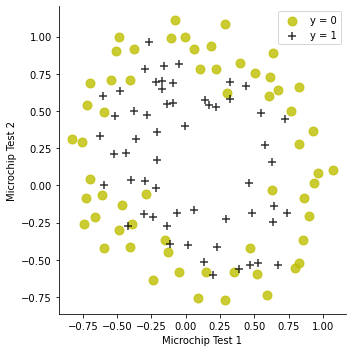

In [15]:
df2 = pd.read_csv('../input/ex2data2.txt')
df2.columns = ['Microchip Test 1', 'Microchip Test 2', 'Accepted']
#df1['Admitted'] = df1['Admitted'].astype('category')

data = df2
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

print(X.shape)
print(y.shape)

# plot with pandas dataframe

ax2 = sns.lmplot(x = 'Microchip Test 1' , y = 'Microchip Test 2', data = df2,
                hue = 'Accepted', 
                markers = ['o', '+'], palette = ['y', 'k'],
                fit_reg=False, scatter_kws = {'s':80}, legend = False)

ax2.set(xlabel = 'Microchip Test 1', ylabel = 'Microchip Test 2')

#ax._legend.set(title = '')
#new_labels = ['Not admitted', 'Admitted']
#for t, l in zip(ax._legend.texts, new_labels): 
#    t.set_text(l)

# add new legend instead of using the legend with sns
plt.legend(title = '', loc = 'upper right', labels = ['y = 0', 'y = 1'])

## 2.2 Feature mapping

In [16]:
def mapFeature(X1, X2):
    '''
    MAPFEATURE Feature mapping function to polynomial features
    
    MAPFEATURE(X1, X2) maps the two input features to quadratic features used in the regularization exercise.

    Returns a new feature array with more features
    X1, X2 - 1d arrays
    '''
    degree = 6
    m = len(X1)
    
    out = np.ones((m,1)) # intercept column - X1^0*X2^0
    
    for i in np.arange(degree) + 1: # 1,2,3,4,5,6
        for j in np.arange(i+1): 
            new_var = (X1**(i-j))*(X2**j)
            
            # update out
            out = np.hstack([out, new_var.reshape(m,1)])
            
            
    return out

In [17]:
# Add Polynomial Features to the sixth power
#Note that mapFeature also adds a column of ones for us, so the intercept term is handled
X_poly = mapFeature(X[:,0], X[:,1])


# Initialize fitting parameters
initial_theta = np.zeros((X_poly.shape[1], 1))


## 2.3 Cost function and gradient

In [18]:
def costFunctionReg(theta, X, y, param_lambda):
    '''
    COSTFUNCTION Compute cost and gradient for logistic regression
    
    J = COSTFUNCTION(theta, X, y) computes the cost of using theta as the
    parameter for logistic regression and 
    
    X - shape (m, n+1)
    theta - nparray shape (n+1,)
    '''
    # Setup the data matrix appropriately, and add ones for the intercept term
    m = X.shape[0]
    n = X.shape[1]-1
    
    m = len(y) # number of training examples
    #n = X.shape[1]-1
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)
    
    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
    
    # sum(-log(h(x))) for y = 1
    y_1_useful = y_prob * y 
    J_y_1_sum = -sum(np.log(y_1_useful[y_1_useful!=0]))
    
    # sum(-log(h(x))) for y = 0
    y_0_useful = (1 - y_prob) * (1-y)
    J_y_0_sum = -sum(np.log(y_0_useful[y_0_useful!=0]))
    
    # regularization term
    loss_reg = sum(theta[1:]**2)*param_lambda/(2*m)
    
    
    return (J_y_1_sum + J_y_0_sum)/m + loss_reg

def gradientFunctionReg(theta, X, y, param_lambda):
    '''
    computes the gradient of the cost w.r.t. to the parameters.
    X - shape (m, n+1)
    theta - nparray shape (n+1,)
    '''
    # Setup the data matrix appropriately, and add ones for the intercept term
    m = X.shape[0]
    n = X.shape[1]-1
    
    
    m = len(y) # number of training examples
    #n = X.shape[1]-1
    y = y.reshape(m,1)
    theta = theta.reshape(n+1,1)

    # h(x)
    y_prob = sigmoid(X @ theta) # (m,1)
    
    return (X.T @ (y_prob - y))/m + np.vstack([0, param_lambda*theta[1:]/m]) # (n+1,1)

In [19]:
# Set regularization parameter lambda to 1
lambda_pick = 1

# Compute and display initial cost and gradient for regularized logistic regression
cost = costFunctionReg(initial_theta, X_poly, y, lambda_pick)
grad = gradientFunctionReg(initial_theta, X_poly, y, lambda_pick) 


print('Cost at initial theta (zeros): {}\n'.format(cost))
print('Gradient at initial theta (zeros): \n{}\n'.format(grad.flatten().tolist()))



Cost at initial theta (zeros): [0.69314718]

Gradient at initial theta (zeros): 
[0.01282051282051282, 0.01916776495726496, 0.003068008547008555, 0.05078616767465384, 0.011752899180905984, 0.040078154574589755, 0.01851345183555408, 0.007394389146565815, 0.008369684636117172, 0.025140192216457198, 0.039684965981326904, 0.002258780692781237, 0.012975462096700625, 0.003197404367994946, 0.04066222960255815, 0.020141438383357003, 0.0043668600899872305, 0.003415664746726006, 0.005891965441950589, 0.004567020871685794, 0.03198900376215415, 0.03129646861574409, 0.0011067829511923228, 0.006369702823656752, 0.0004121916238020609, 0.007329827597113475, 0.0014249332090266282, 0.03962608619336864]



### 2.3.1 Learning parameters using fmin_tnc

In [20]:
from scipy.optimize import fmin_tnc

# get optimal theta
temp = fmin_tnc(func = costFunctionReg, x0 = initial_theta, fprime= gradientFunctionReg, args = (X_poly, y, lambda_pick))

theta = temp[0]
# Print theta to screen
print('Cost at theta found by fminunc: {}\n'.format(costFunctionReg(theta, X_poly, y, lambda_pick)))
print('theta: \n{}\n'.format(theta))

Cost at theta found by fminunc: [0.53040753]

theta: 
[ 1.25723705  0.61812465  1.15134374 -1.99067944 -0.92090352 -1.44686543
  0.1271611  -0.3434408  -0.36099965 -0.1793736  -1.45410588 -0.04724003
 -0.60274445 -0.27701628 -1.18790241 -0.24240983 -0.19950713 -0.04328086
 -0.26793983 -0.29784933 -0.44416639 -1.04441741  0.02966498 -0.28948186
  0.01695701 -0.3208404  -0.14558627 -0.90826376]



## 2.4 Evaluation

In [21]:
def predictReg(theta, X):
    '''
    PREDICT Predict whether the label is 0 or 1 using learned logistic regression parameters theta
    p = PREDICT(theta, X) computes the predictions for X using a threshold at 0.5 
    (i.e., if sigmoid(theta'*x) >= 0.5, predict 1)
    
    returns a 1d array with binary predictions
    '''
    m = X.shape[0]
    n = X.shape[1]-1
    
    m = len(y) # number of training examples
    #n = X.shape[1]-1
    theta = theta.reshape(n+1,1)
    
    y_prob = sigmoid(X @ theta)
    
    y_pred = (y_prob >= 0.5).astype(int)
    
    return y_pred.flatten()

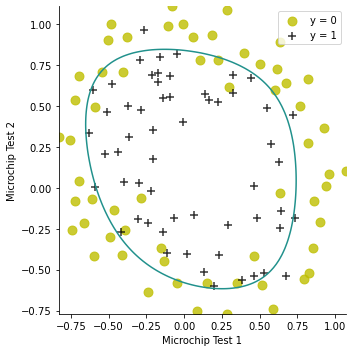

In [22]:
ax3 = sns.lmplot(x = 'Microchip Test 1' , y = 'Microchip Test 2', data = df2,
                hue = 'Accepted', 
                markers = ['o', '+'], palette = ['y', 'k'],
                fit_reg=False, scatter_kws = {'s':80}, legend = False)

ax3.set(xlabel = 'Microchip Test 1', ylabel = 'Microchip Test 2')


u = np.linspace(min(df2['Microchip Test 1']), max(df2['Microchip Test 1']), 100)
v = np.linspace(min(df2['Microchip Test 2']), max(df2['Microchip Test 2']), 100)

z = np.zeros((len(u), len(v)))
# evaluate z = x @ theta over the grid
for i in np.arange(len(u)):
    for j in np.arange(len(v)):
        z[i,j] = mapFeature(np.array([u[i]]), np.array([v[j]])) @ theta

plt.contour(u, v, z.T, 0)

# add new legend instead of using the legend with sns
plt.legend(title = '', loc = 'upper right', labels = ['y = 0', 'y = 1'])

In [23]:

# Compute accuracy on our training set
p = predictReg(theta, X_poly);

print('Train Accuracy: %{:.2f}\n'.format(np.mean(p == y)*100))

Train Accuracy: %82.91



In [24]:
X_poly.shape

(117, 28)

In [25]:
data = df2
X = X_poly[:,1:]
y = data.iloc[:,2].values
m = len(y)


from sklearn.linear_model import LogisticRegression

regression_model = LogisticRegression(penalty = 'l2', solver = 'newton-cg', max_iter = 400)
regression_model.fit(X, y)

#thetas = [i for i in regression_model.coef_[0]]
print('Theta found by Scikit-Learn: {:.4f}, '.format(regression_model.intercept_[0]))
print(', '.join('{:.4f}'.format(i) for i in regression_model.coef_[0]))

Theta found by Scikit-Learn: 1.2572, 
0.6181, 1.1514, -1.9906, -0.9209, -1.4469, 0.1271, -0.3434, -0.3610, -0.1794, -1.4541, -0.0473, -0.6028, -0.2770, -1.1879, -0.2424, -0.1995, -0.0433, -0.2679, -0.2979, -0.4441, -1.0444, 0.0297, -0.2895, 0.0170, -0.3208, -0.1456, -0.9082


In [26]:
theta = np.append(regression_model.intercept_, regression_model.coef_[0])
# Compute accuracy on our training set
p = predictReg(theta, X_poly)

print('Train Accuracy: %{:.2f}\n'.format(np.mean(p == y)*100))

Train Accuracy: %82.91

